In [10]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, datasets, models

In [11]:
import pathlib

# load in dataset
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

In [12]:
# count how many images
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


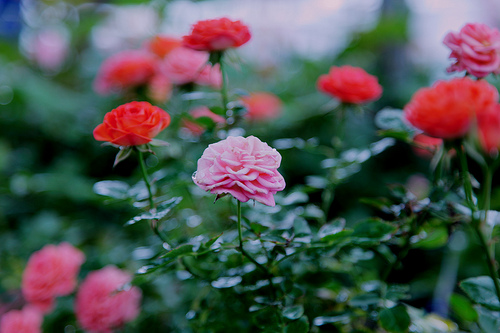

In [13]:
# display one class
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

In [17]:
# define parameters for loader
batch_size = 32
img_height = 180
img_width = 180

# 80% images for training, 20% for validation
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

# def split_dataset(ds, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, shuffle=True):
#     dataset_size = len(ds)
#     train_size = int(train_ratio * dataset_size)
#     val_size = int(val_ratio * dataset_size)
#     test_size = dataset_size - train_size - val_size
#     if shuffle:
#         ds = ds.shuffle(dataset_size)
#     train_dataset = ds.take(train_size)
#     val_dataset = ds.skip(train_size).take(val_size)
#     test_dataset = ds.skip(train_size + val_size).take(test_size)
#     return train_dataset, val_dataset, test_dataset
# 
# train_ds, val_ds, test_ds = split_dataset(dataset)

class_names = train_ds.class_names
print(class_names)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


2024-08-10 08:03:12.834347: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(32, 180, 180, 3)
(32,)


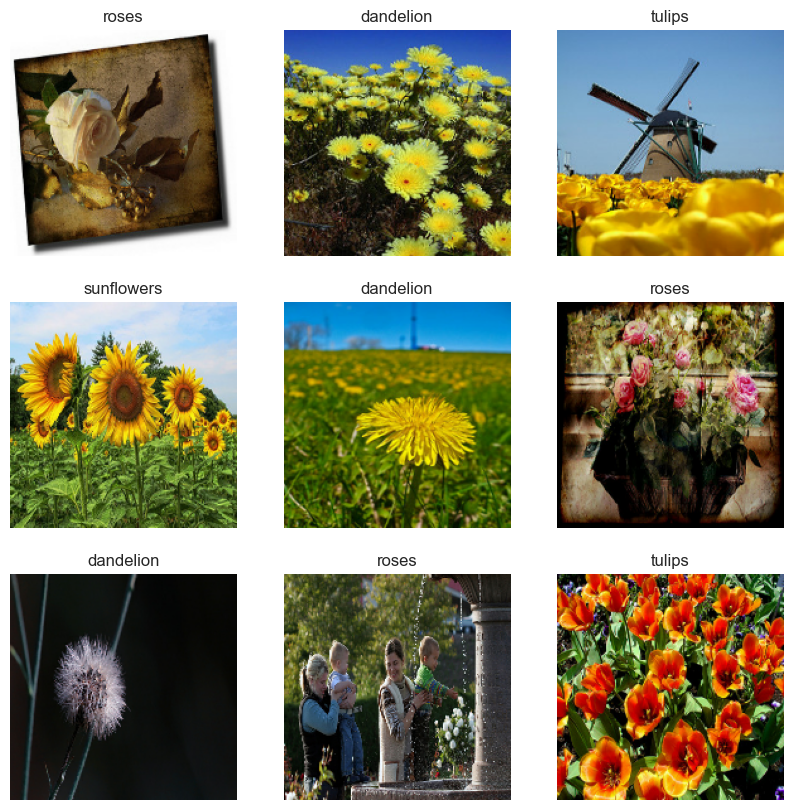

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

In [21]:
AUTOTUNE = tf.data.AUTOTUNE

# .cache keeps images in memory after loaded off disk during the first epoch. if dataset is too large, it creates a performant on- disk cache.
# .prefetch overlaps data preprocessing and model execution while training
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# true_label = np.concatenate([y for x, y in train_ds], axis=0)
# print(true_label)
# img = np.concatenate([x for x, y in train_ds], axis=0)
# print(img)
true_label, img = [], []
for x, y in train_ds:
    true_label.append(y)
    img.append(x)
true_label = np.concatenate(true_label)
img = np.concatenate(img)
print(true_label)

# standardize data to 0-1, RGB from 1-255 
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

2024-08-10 08:04:21.057667: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[3 1 0 ... 1 1 1]
0.0 1.0


In [57]:
num_classes = len(class_names)

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal",
                          input_shape=(img_height,
                                       img_width,
                                       3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

model = models.Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    # layers.Conv2D(16, 3, padding='same', activation='relu'),
    # layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_6 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [58]:
history = model.fit(train_ds, epochs=10, batch_size=64, validation_data=val_ds)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 25s 262ms/step - accuracy: 0.2915 - loss: 3.0414 - val_accuracy: 0.5068 - val_loss: 1.2224
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 251ms/step - accuracy: 0.5399 - loss: 1.1643 - val_accuracy: 0.6008 - val_loss: 1.0571
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 241ms/step - accuracy: 0.5882 - loss: 1.0148 - val_accuracy: 0.5954 - val_loss: 1.0857
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 234ms/step - accuracy: 0.6314 - loss: 0.9435 - val_accuracy: 0.6294 - val_loss: 0.9721
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 236ms/step - accuracy: 0.6365 - loss: 0.9309 - val_accuracy: 0.6240 - val_loss: 0.9953
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 234ms/step - accuracy: 0.6722 - loss: 0.8417 - val_accuracy: 0.6471 - val_loss: 0.9351
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 236ms/step - accuracy: 0.6917 - loss: 0.7878 - val_accuracy: 0.6580 - val_loss: 0.9001
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 243ms/step - accuracy: 0.6996 - loss: 0.7721 - val_accu

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


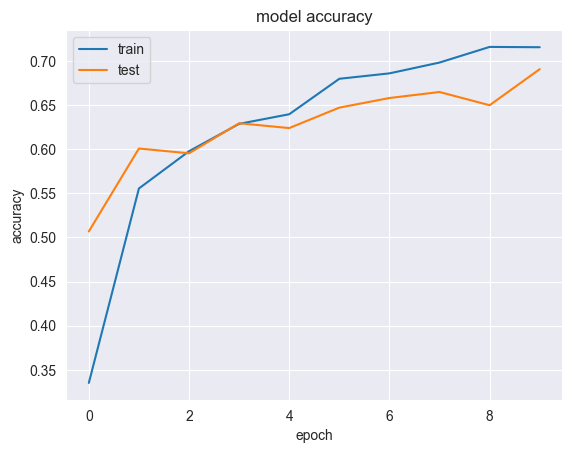

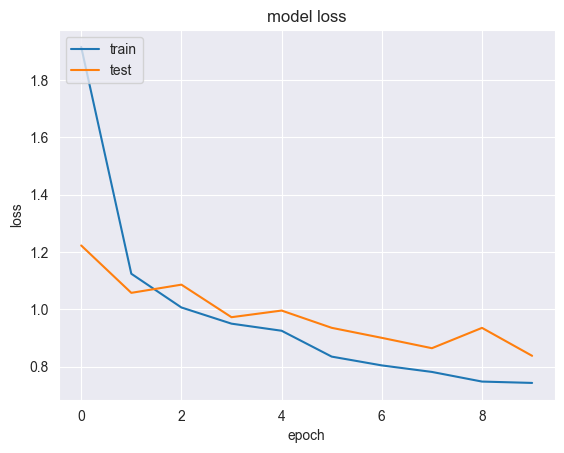

In [59]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [60]:
true_label, img = [], []
for x, y in val_ds:
    true_label.append(y)
    img.append(x)
true_label = np.concatenate(true_label)
img = np.concatenate(img)
print(true_label)

predictions = model.predict(img)

print(predictions)

# score = [tf.nn.softmax(predictions[i], axis=1) for i in range(len(predictions))]
score = tf.nn.softmax(predictions)

# print(score)

idx = np.argmax(score, axis=1)
# print(sum(score[1]))

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[idx[1]], 100 * np.max(score[1]))
)

[1 0 3 2 4 2 3 1 2 4 4 1 1 1 3 3 0 4 1 2 0 3 4 1 4 4 0 1 2 3 1 3 1 2 2 0 2
 1 4 2 2 3 1 3 4 1 4 0 0 0 2 1 0 0 3 3 3 4 2 4 2 0 1 2 3 1 0 2 0 2 4 1 2 3
 3 4 1 2 4 4 4 1 2 1 4 2 3 3 0 3 0 2 2 0 4 2 4 2 1 0 1 4 2 4 4 3 0 0 0 0 0
 0 2 0 3 4 1 0 3 4 4 1 4 4 3 3 4 3 0 2 3 4 1 4 0 3 1 1 3 1 3 4 1 1 3 3 0 1
 0 3 0 1 3 3 2 2 4 3 0 3 1 3 3 1 4 1 4 0 4 4 4 4 3 1 2 2 4 0 3 3 1 4 0 0 1
 0 3 0 3 4 4 2 1 1 4 0 4 1 1 1 2 3 0 1 3 4 3 0 1 4 0 2 4 2 0 0 1 3 2 2 3 3
 1 2 3 2 1 0 3 4 1 4 1 0 0 2 3 1 4 2 2 1 3 0 4 0 2 4 3 0 1 2 0 1 3 3 4 0 2
 2 0 3 2 1 0 4 2 3 2 4 0 4 1 2 3 2 4 2 1 1 3 1 1 2 3 0 2 3 3 2 3 2 0 0 1 1
 2 1 4 4 2 0 2 1 0 3 3 0 4 2 4 4 3 3 4 4 1 4 1 1 1 0 3 3 1 0 1 4 1 1 2 1 0
 3 4 1 4 2 0 4 1 4 1 3 2 3 3 0 2 1 0 4 1 0 1 1 2 4 3 0 4 0 2 4 0 0 4 4 3 1
 4 4 4 2 1 3 2 1 0 4 0 1 1 0 2 3 1 3 1 3 1 0 2 0 1 1 4 1 4 3 0 4 4 0 2 4 1
 3 2 3 1 2 0 1 1 1 4 3 2 3 3 1 3 4 3 1 1 0 3 1 4 1 1 0 1 2 4 1 4 3 3 1 3 0
 1 4 0 0 2 3 0 2 4 4 1 2 4 4 1 1 3 2 1 0 3 4 2 3 0 2 3 4 4 2 3 4 4 1 3 4 3
 1 4 0 1 4 4 4 2 1 1 0 3 

In [61]:
# for one specific image that was not in training or validation sets
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img1 = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
print(img1)

img_array = tf.keras.utils.img_to_array(img1)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions1 = model.predict(img_array)
score1 = tf.nn.softmax(predictions1[0])
print(predictions1)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score1)], 100 * np.max(score1))
)

<PIL.Image.Image image mode=RGB size=180x180 at 0x28FDF0390>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[[-5.341501  -2.2661984  2.7731483  8.035111   4.609191 ]]
This image most likely belongs to sunflowers with a 96.36 percent confidence.


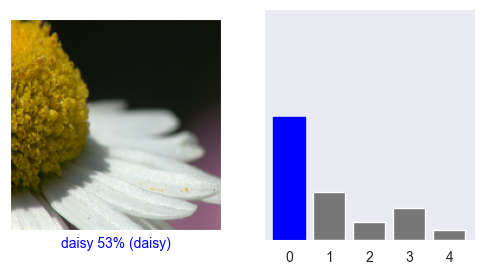

In [62]:
def plot_image(j, predictions_array, true_label, img):
    true_label, img = true_label[j], img[j] / 255.0
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    score1 = tf.nn.softmax(predictions_array)
    predicted_label = np.argmax(score1)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(score1),
                                         class_names[true_label]),
               color=color)

def plot_value_array(k, predictions_array, true_label):
    true_label = true_label[k]
    plt.grid(False)
    plt.xticks(range(5))
    plt.yticks([])
    
    score1 = tf.nn.softmax(predictions_array)
    thisplot = plt.bar(range(5), score1, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(score1)
    # print(score1)

    thisplot[true_label].set_color('red')
    thisplot[predicted_label].set_color('blue')

i = 1
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], true_label, img)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i], true_label)
plt.show()

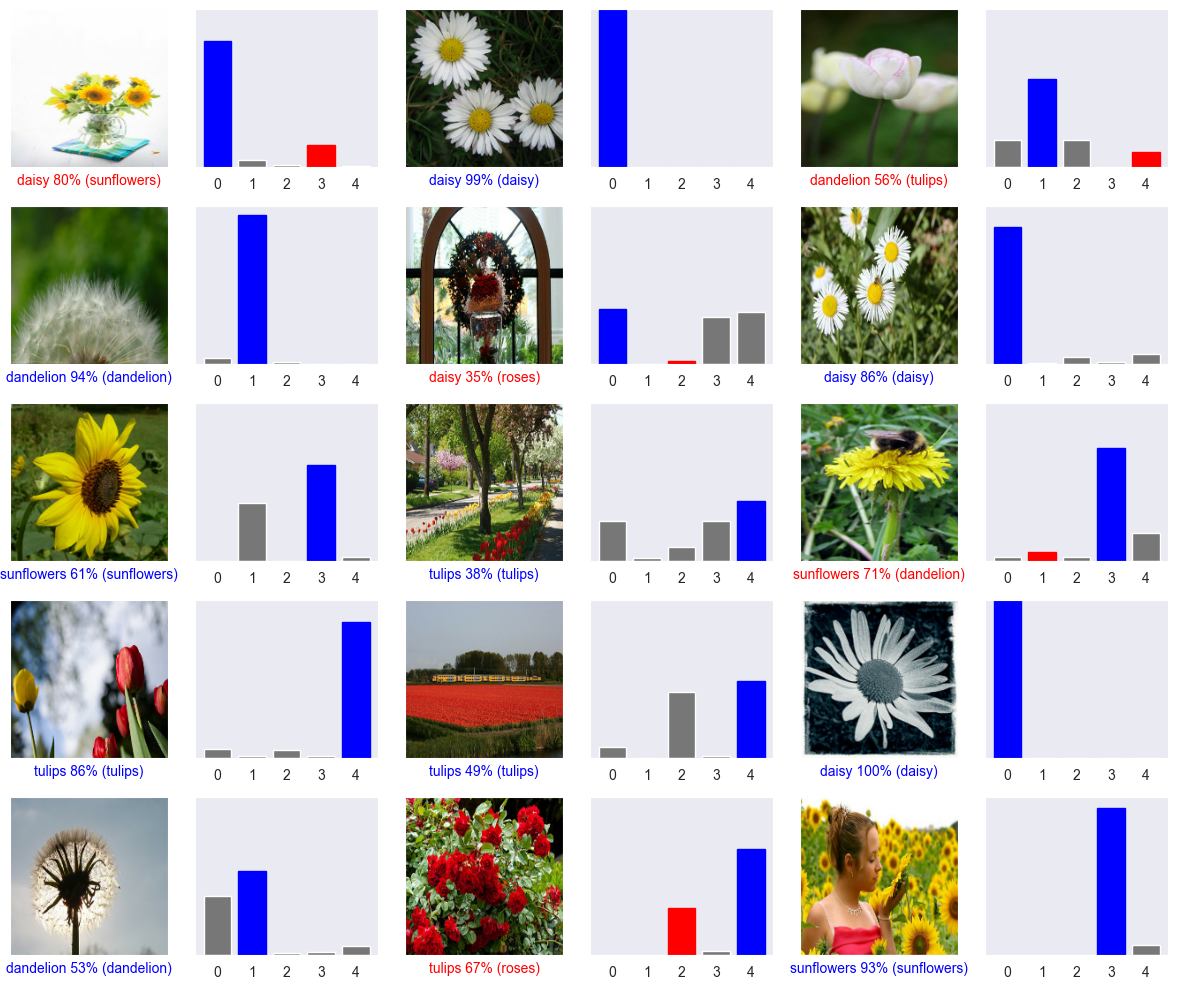

In [69]:
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
k = 15
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i + k, predictions[i + k], true_label, img)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i + k, predictions[i + k], true_label)
plt.tight_layout()
plt.show()
# data we loaded is not correct by comparing the images and labels below